# Prediction Abalone Age

In [1]:
import pandas as pd # to manipulate and load data | pip install pandas
import numpy as np # to manipulate data and do calculations | pip install numpy
import matplotlib.pyplot as plt # to visualize plots | pip install matploblib
import seaborn as sns # to do plots | pip install seabron

from sklearn.preprocessing import OrdinalEncoder # to encode categorical variables | pip isntall scikit-learn
from sklearn.preprocessing import StandardScaler # to normaliza data | pip install scikit-learn

from sklearn.model_selection import train_test_split # to split data into train-test | pip install scikit-learn

from sklearn.ensemble import RandomForestRegressor # to initialize Random Forest Regressor model | pip install scikit-learn
from sklearn.svm import SVR # to initialize Support Vector Regressor | pip install scikit-learn
from xgboost import XGBRegressor # to initialize X-treme Gradient Boosting Regressor | pip install xgboost
from sklearn.tree import DecisionTreeRegressor # to initialize Decision Tree Regressor | pip install scikit-learn
from sklearn.ensemble import BaggingRegressor # to perform Bagging Regressor | pip install scikit-learn
from sklearn.ensemble import VotingRegressor # to perform Voting Regressor | pip install scikit-learn

from sklearn.model_selection import GridSearchCV # to tune hyper-parameters | pip install scikit-learn (you can also try RadomSearchCV)

from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score # to evaluate models | pip install scikit-learn (try regression metrics)

import warnings
warnings.filterwarnings("ignore")

In [2]:
def clean_outliers(df, variable, method = "quantile", n = 3): #this functions is to clean outliers
    if method == "std": # using n*std method
        media = df[variable].mean()
        std = df[variable].std()
        upper = media + n*std
        lower = media - n*std
        return np.where(df[variable] > upper, upper, np.where(df[variable] < lower, lower, df[variable])) #replacing outliers with upper and lower bound
    
    elif method == "quantile": # IQR method
        Q1 = df[variable].quantile(0.25)
        Q3 = df[variable].quantile(0.75)
        IQR = Q3 - Q1
        upper = Q3 + 1.5*IQR
        lower = Q1 - 1.5*IQR
        return np.where(df[variable] > upper, upper, np.where(df[variable] < lower, lower, df[variable])) # replacing with upper and lower bound
    
    elif method == "mean": # mean method
        media = df[variable].mean()
        std = df[variable].std()
        upper = media + n*std
        lower = media - n*std
        return np.where(df[variable] > upper, media, np.where(df[variable] < lower, media, df[variable])) #replacing with mean

def view_correlation_matrix(df, cmap = 'coolwarm'):
    display(df.select_dtypes(include = 'number').corr().style.background_gradient(cmap = cmap)) # display correaltion diagram

# Load Data

In [3]:
data = pd.read_csv('abalone.csv') # load the data

In [4]:
data # take a look to the data 

,Type,LongestShell,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


# Missing values

In [5]:
data.isna().sum() # check for missing values (there is no missing values)

Type             0
LongestShell     0
Diameter         0
Height           0
WholeWeight      0
ShuckedWeight    0
VisceraWeight    0
ShellWeight      0
Rings            0
dtype: int64

# EDA

In [6]:
data.describe() # take a brief description of the data (numeric)

,LongestShell,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [7]:
data.Type.value_counts() # take a brief description of categorial variables 

Type
M    1528
I    1342
F    1307
Name: count, dtype: int64

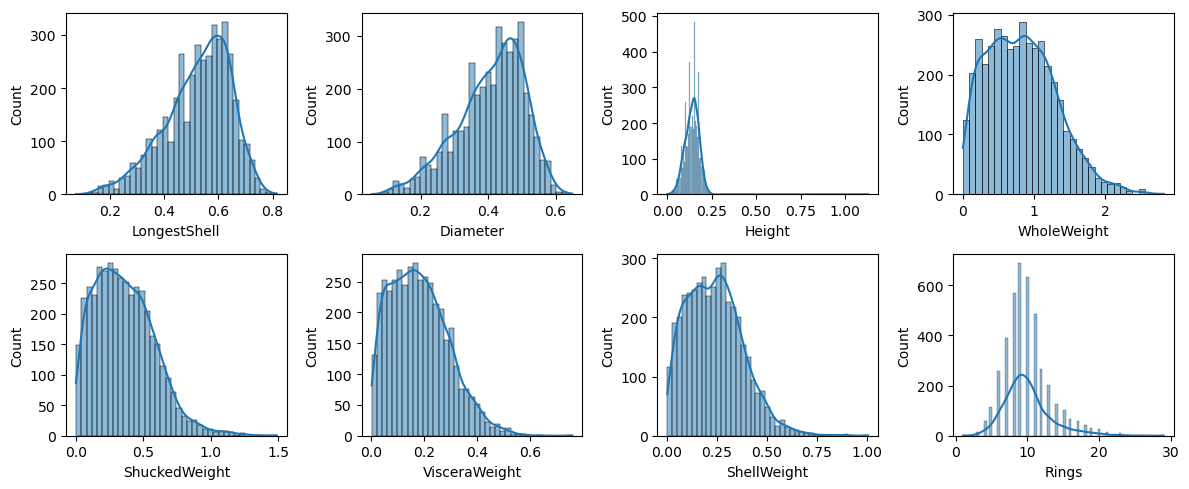

In [8]:
fig, axes = plt.subplots(2, 4, figsize=(12, 5)) # create subplots to graph every variable

sns.histplot(ax = axes[0, 0], x=data['LongestShell'], kde=True)
sns.histplot(ax = axes[0, 1], data=data, x='Diameter', kde=True)
sns.histplot(ax = axes[0, 2], x=data['Height'], kde=True)
sns.histplot(ax = axes[0, 3], data=data, x='WholeWeight', kde=True)

sns.histplot(ax = axes[1, 0], x=data['ShuckedWeight'], kde=True)
sns.histplot(ax = axes[1, 1], data=data, x='VisceraWeight', kde=True)
sns.histplot(ax = axes[1, 2], x=data['ShellWeight'], kde=True)
sns.histplot(ax = axes[1, 3], data=data, x='Rings', kde=True)
plt.tight_layout() 
plt.show()

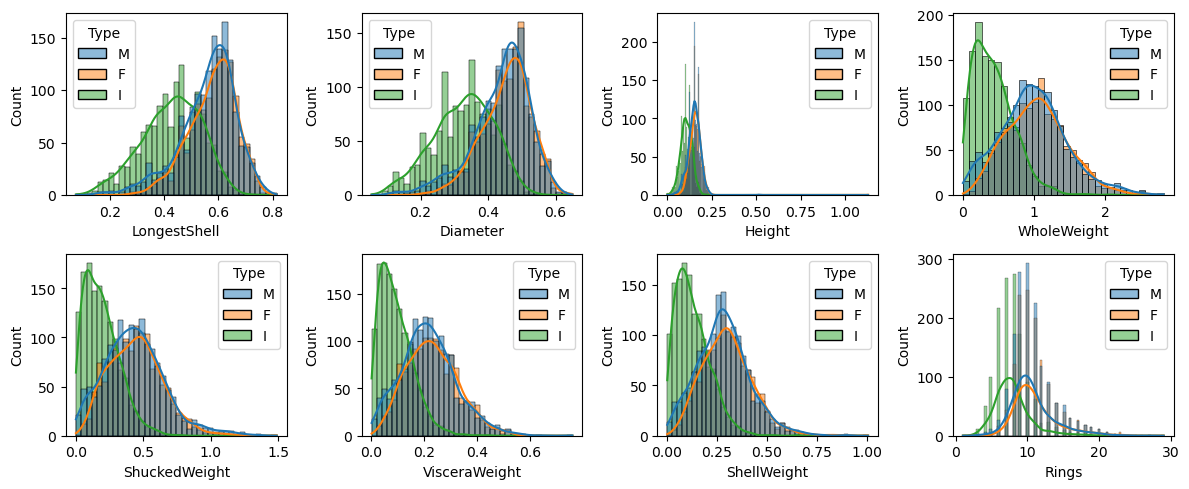

In [9]:
fig, axes = plt.subplots(2, 4, figsize=(12, 5)) # create descriptions to graph every variable but using 'Type' as a segmentation

sns.histplot(ax = axes[0, 0], x='LongestShell', data = data, hue = 'Type', kde=True)
sns.histplot(ax = axes[0, 1], data=data, x='Diameter', hue = 'Type', kde=True)
sns.histplot(ax = axes[0, 2], x='Height',data = data, hue = 'Type', kde=True)
sns.histplot(ax = axes[0, 3], data=data, x='WholeWeight', hue = 'Type', kde=True)

sns.histplot(ax = axes[1, 0], x='ShuckedWeight', data = data, hue = 'Type', kde=True)
sns.histplot(ax = axes[1, 1], data=data, x='VisceraWeight', hue = 'Type',kde=True)
sns.histplot(ax = axes[1, 2], x='ShellWeight',data = data,hue = 'Type', kde=True)
sns.histplot(ax = axes[1, 3], data=data, x='Rings',hue = 'Type', kde=True)
plt.tight_layout() 
plt.show()

In [10]:
view_correlation_matrix(data, cmap = 'coolwarm') #check for correlation

,LongestShell,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings
LongestShell,1.000000,0.986812,0.827554,0.925261,0.897914,0.903018,0.897706,0.556720
Diameter,0.986812,1.000000,0.833684,0.925452,0.893162,0.899724,0.905330,0.574660
Height,0.827554,0.833684,1.000000,0.819221,0.774972,0.798319,0.817338,0.557467
WholeWeight,0.925261,0.925452,0.819221,1.000000,0.969405,0.966375,0.955355,0.540390
ShuckedWeight,0.897914,0.893162,0.774972,0.969405,1.000000,0.931961,0.882617,0.420884
VisceraWeight,0.903018,0.899724,0.798319,0.966375,0.931961,1.000000,0.907656,0.503819
ShellWeight,0.897706,0.905330,0.817338,0.955355,0.882617,0.907656,1.000000,0.627574
Rings,0.556720,0.574660,0.557467,0.540390,0.420884,0.503819,0.627574,1.000000


# Drop Correlated columns

In [11]:
data.drop(columns = ["Diameter"], inplace = True)

# Data Cleaning

In [12]:
numeric_columns = data.drop(columns = ["Rings"]).select_dtypes(include=['number']) # get numeric columns  (do not consider target column)
non_numeric_columns = data.drop(columns = ["Rings"]).select_dtypes(exclude=['number']) # get categorical columns (do not consider target column)

In [13]:
for i in numeric_columns.columns: # clean outliers using 3 std rule, using std method
    data[i] = clean_outliers(data, i, method = "std", n = 3)

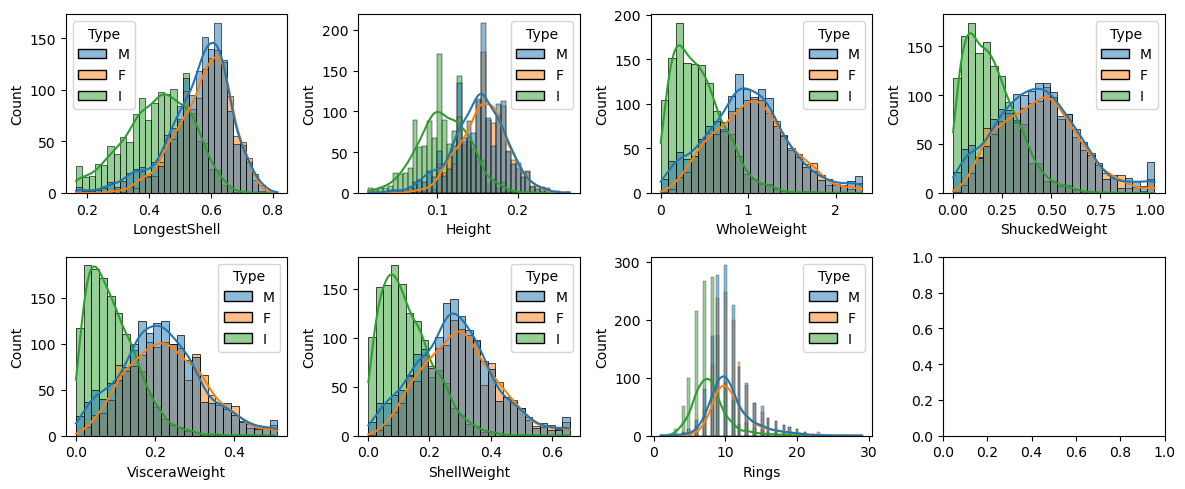

In [17]:
fig, axes = plt.subplots(2, 4, figsize=(12, 5)) # visualize the subplots again

sns.histplot(ax = axes[0, 0], x='LongestShell', data = data, hue = 'Type', kde=True)
sns.histplot(ax = axes[0, 1], x='Height',data = data, hue = 'Type', kde=True)
sns.histplot(ax = axes[0, 2], data=data, x='WholeWeight', hue = 'Type', kde=True)

sns.histplot(ax = axes[0, 3], x='ShuckedWeight', data = data, hue = 'Type', kde=True)
sns.histplot(ax = axes[1, 0], data=data, x='VisceraWeight', hue = 'Type',kde=True)
sns.histplot(ax = axes[1, 1], x='ShellWeight',data = data,hue = 'Type', kde=True)
sns.histplot(ax = axes[1, 2], data=data, x='Rings',hue = 'Type', kde=True)
plt.tight_layout() 
plt.show()

In [16]:
view_correlation_matrix(data, cmap = 'coolwarm') # visualize the correlation again

,LongestShell,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings
LongestShell,1.000000,0.898278,0.928222,0.905180,0.906287,0.905697,0.556426
Height,0.898278,1.000000,0.888507,0.840845,0.866869,0.893367,0.607787
WholeWeight,0.928222,0.888507,1.000000,0.970814,0.967265,0.959399,0.541593
ShuckedWeight,0.905180,0.840845,0.970814,1.000000,0.934798,0.891931,0.425461
VisceraWeight,0.906287,0.866869,0.967265,0.934798,1.000000,0.915027,0.505537
ShellWeight,0.905697,0.893367,0.959399,0.891931,0.915027,1.000000,0.626977
Rings,0.556426,0.607787,0.541593,0.425461,0.505537,0.626977,1.000000


# Standarizing and Encoding

In [18]:
encoder = OrdinalEncoder() # initialize encoder (you can use one hot encoder)
scaler = StandardScaler() # initialize Scaler 

In [19]:
scaler_cols = list(numeric_columns.columns) # take numeric columns to standarize
encoder_cols = list(non_numeric_columns.columns) # take categorical columns to encode

data[scaler_cols] = scaler.fit_transform(data[scaler_cols]) # fit_transfrom the data
data[encoder_cols] = encoder.fit_transform(data[encoder_cols]) # fit_transform the data

# Train and Test Data

In [21]:
X = data.drop(columns = ['Rings']) # select features to predict
y = data["Rings"] # select target column

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # split into training and testing data
# change the ratio if you want (80 - 20, you can use 75 - 25, 70 - 30)

# Models

In [23]:
rfr = RandomForestRegressor() # try to train and test a variety of models
svr = SVR()
xgb = XGBRegressor()
dtr = DecisionTreeRegressor()

In [24]:
models = [rfr, svr, xgb, dtr] # this is to visualize results easier
model_names = [type(x).__name__ for x in models]

In [25]:
for i in models: #train every model
    i.fit(X_train, y_train)

# Hyper Parameter - Tunning
 - From the last models the best was "RFR", so we are going to tune its parameters

In [26]:
param_grid = { # check for more parameters in scikit-learn documentation of random forest regressor
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
}

In [27]:
grid_search = GridSearchCV(estimator=rfr, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring = 'neg_mean_squared_error' )
# initialize gridsearcv with model, 5 cross-validation, using every processor and scoring as mean_squared_Error (you can modify this parameters as you please)

In [28]:
grid_search.fit(X_train, y_train) # train GridSearchCV

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error', verbose=2)

In [29]:
cv_results_df = pd.DataFrame(grid_search.cv_results_) # visualize the results in a dataframe

In [30]:
cv_results_df[cv_results_df["rank_test_score"] < 6].sort_values("rank_test_score") # check best 5 results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
16,3.659259,0.059436,0.050064,0.005219,10,10,200,"{'max_depth': 10, 'min_samples_split': 10, 'n_...",-4.122349,-5.177092,-4.978276,-4.573422,-4.103884,-4.591004,0.436053,1
15,1.835716,0.029321,0.024264,0.000946,10,10,100,"{'max_depth': 10, 'min_samples_split': 10, 'n_...",-4.145167,-5.239859,-4.956843,-4.594143,-4.095991,-4.606401,0.446650,2
17,5.899367,0.376578,0.075091,0.012200,10,10,300,"{'max_depth': 10, 'min_samples_split': 10, 'n_...",-4.148297,-5.211562,-5.012225,-4.563297,-4.148025,-4.616681,0.436397,3
13,3.939979,0.089186,0.052307,0.004336,10,5,200,"{'max_depth': 10, 'min_samples_split': 5, 'n_e...",-4.204884,-5.222327,-4.994865,-4.594313,-4.089878,-4.621253,0.437567,4
14,5.753899,0.090305,0.070354,0.003202,10,5,300,"{'max_depth': 10, 'min_samples_split': 5, 'n_e...",-4.174464,-5.200215,-5.042139,-4.616058,-4.101964,-4.626968,0.443055,5


In [31]:
best_model = grid_search.best_estimator_ # get best estimator
models.append(best_model) # append it to models
model_names.append(type(best_model).__name__ + " best") # append its name 

# Trying Bagging Regressor 

In [32]:
bagging_regressor = BaggingRegressor(base_estimator=best_model, # take the best model and use bagging to improve performance 
                                     n_estimators=100, # change the parameters as you please, check out documentation to get more parameters
                                     random_state=42)

bagging_regressor.fit(X_train, y_train) # train bagging regressor

models.append(bagging_regressor) # append it to models
model_names.append(type(bagging_regressor).__name__) # append its name 

# Trying Voting Regressor 

In [33]:
voting_regressor = VotingRegressor([('rfr', best_model), ('bagging', bagging_regressor)]) # take as many models as you want ( I took best 2) 
voting_regressor.fit(X_train, y_train) # train voting regressor 

models.append(voting_regressor) # append it to models
model_names.append(type(voting_regressor).__name__) # append its name 

In [35]:
feature_importances = best_model.feature_importances_ # check for feature importance of the best model (RFR)

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances}) 
feature_importance_df.sort_values(by='Importance', ascending=False) # sort by importance

,Feature,Importance
6,ShellWeight,0.591829
4,ShuckedWeight,0.177520
3,WholeWeight,0.077558
5,VisceraWeight,0.047048
2,Height,0.046295
1,LongestShell,0.041305
0,Type,0.018445


# Evaluating Metrics

In [37]:
# create metrics lists
mse = []
rmse = []
mae = []

In [38]:
final_data = pd.DataFrame({"Real Value": y_test}) # create a dataframe with real value to compare it more pricesily

In [39]:
for mdl, name in zip(models, model_names): # iterate over models
    mse.append(mean_squared_error(y_test,mdl.predict(X_test))) # compute MSE for every model
    rmse.append(np.sqrt(mean_squared_error(y_test,mdl.predict(X_test)))) # compute RMSE for every model
    mae.append(mean_absolute_error(y_test,mdl.predict(X_test))) # compute MAE for every model

    final_data[name] = mdl.predict(X_test) # compute predictions and append them to data_final

In [40]:
final_data # check results

,Real Value,RandomForestRegressor,SVR,XGBRegressor,DecisionTreeRegressor,RandomForestRegressor best,BaggingRegressor,VotingRegressor
866,9,12.50,11.278190,11.543617,13.0,12.379303,12.302634,12.075698
1483,8,9.15,9.565727,9.463722,9.0,9.665775,9.685034,9.690695
599,16,14.78,13.715243,13.650317,18.0,14.946076,14.628201,14.485886
1702,9,10.85,11.112116,10.855221,8.0,10.932620,10.992343,10.949912
670,14,12.45,11.314514,10.221228,13.0,12.308285,12.217117,12.279335
...,...,...,...,...,...,...,...,...
3093,11,10.39,10.878259,9.875902,9.0,10.725407,10.930442,10.782575
1651,8,9.87,9.674331,10.029592,10.0,9.830276,9.869092,9.852813
2897,10,8.77,8.943566,8.832492,9.0,9.032680,9.117691,9.111800
3953,8,9.55,8.906291,8.733356,8.0,9.451172,9.410662,9.390937


In [41]:
results = pd.DataFrame({"Model": model_names, "MSE": mse, "RMSE": rmse, "MAE": mae}) # create metrics

In [42]:
results # check metrics

,Model,MSE,RMSE,MAE
0,RandomForestRegressor,4.967829,2.228863,1.562488
1,SVR,4.942528,2.223180,1.519127
2,XGBRegressor,5.662161,2.379530,1.662136
3,DecisionTreeRegressor,9.472488,3.077741,2.127990
4,RandomForestRegressor best,4.952298,2.225376,1.551195
5,BaggingRegressor,4.806445,2.192360,1.537026
6,VotingRegressor,4.865158,2.205710,1.543387


# Conclussion

## Best Model
 - the best model is the Baggin Regressor after optimizing the Random Forest Regressor as model input, which is the model generally performed better in every metric for this problem.